In [404]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [405]:
type(twenty_train)

sklearn.utils.Bunch

In [406]:
print(twenty_train.keys())
print("Cantidad de clases: ",len(twenty_train.target_names))

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
Cantidad de clases:  20


De estos tipos de datos me van a interesar data pq contiene el texto que quiero clasificar y target/target_names que son las clases en las que quiero clasificar los textos

In [407]:
data_len = len(twenty_train['data'])
print('Dataset length:',data_len)

Dataset length: 11314


Guarde el largo de mi dataset

In [408]:
twenty_train['data'][0].split('\n')

['I was wondering if anyone out there could enlighten me on this car I saw',
 'the other day. It was a 2-door sports car, looked to be from the late 60s/',
 'early 70s. It was called a Bricklin. The doors were really small. In addition,',
 'the front bumper was separate from the rest of the body. This is ',
 'all I know. If anyone can tellme a model name, engine specs, years',
 'of production, where this car is made, history, or whatever info you',
 'have on this funky looking car, please e-mail.']

Una vez con una idea de los datos podemos empezar a procesar los datos.

Vamos a separar estos textos en palabras individuales (tokenizar), lematizar, quitar las palabras que sean muy repetitivas del idioma y reemplazar algunas palabras por su raiz

In [432]:
def treat_data(data, lemm=True, stem=True, stop=True):
    lem = WordNetLemmatizer()
    stemm = PorterStemmer()
    stop_words = stopwords.words('english')
    p_data = [word_tokenize(x) for x in data]
    print("Tokenize ready")
    
    if lemm:
        p_data = [[lem.lemmatize(y) for y in x ] for x in p_data]
        print("Lammatize ready")
    if stop:
        p_data = [[x for x in y if x not in stop_words] for y in p_data]
        print("Stop remove ready")
    if stem:
        p_data = [[stemm.stem(x) for x in y] for y in p_data]
        print("Stemmed ready")
    
    p_data = [[x for x in y if x.isalpha()] for y in p_data]
    print("Finished")
    return [' '.join(x) for x in p_data]

In [34]:
f = open('Cache/tokenized.pkl', 'wb')
pickle.dump(tokenized, f)
f.close()

f = open('Cache/lemmatized.pkl', 'wb')
pickle.dump(lemmatized, f)
f.close()   

f = open('Cache/stopped.pkl', 'wb')
pickle.dump(stopped, f)
f.close()   

f = open('Cache/stemmed.pkl', 'wb')
pickle.dump(stemmed, f)
f.close()   

f = open('Cache/only_alpha.pkl', 'wb')
pickle.dump(only_alpha, f)
f.close()   

In [36]:
f = open('Cache/tokenized.pkl', 'rb')
tokenized = pickle.load(f)
f.close()

f = open('Cache/lemmatized.pkl', 'rb')
lemmatized = pickle.load(f)
f.close()   

f = open('Cache/stopped.pkl', 'rb')
stopped = pickle.load(f)
f.close()   

f = open('Cache/stemmed.pkl', 'rb')
stemmed = pickle.load(f)
f.close()   

f = open('Cache/only_alpha.pkl', 'rb')
only_alpha = pickle.load(f)
f.close()   

In [433]:
procesado = treat_data(twenty_train['data'])
len(procesado)

Tokenize ready
Lammatize ready
Stop remove ready
Stemmed ready
Finished


In [436]:
#instancio un count vectorizer para pasar los strings a vectores
vector = CountVectorizer()
# Armo el vocabulario
vector.fit(procesado)
# Paso el volcabulario a matriz y cuenta la cantidad de veces que aparecen port articulo
X_train = vector.transform(procesado)

Ahora voy a hacer un analisis de cuanto aparecen las palabras para determinar posibles valores para max_df y min_df 

[]

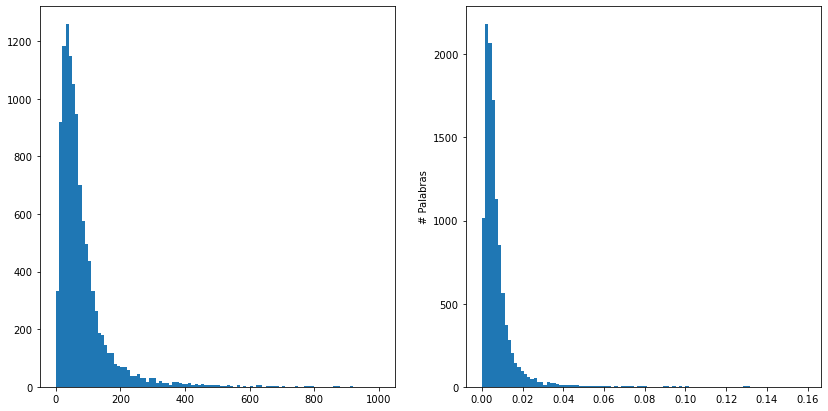

In [452]:
# Me fijo el document frequency
times = np.array([x.count_nonzero() for x in X_train])
times_r = times/X_train.shape[0]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(times, bins=100, range=[0,1000]) #creamos el gráfico en Seaborn
axs[1].hist(times_r, bins=100) #creamos el gráfico en Seaborn
plt.ylabel("# Palabras")
plt.plot()

In [453]:
len(vector.vocabulary_)

48681

De los graficos se puede observar que son pocas las palabras que se enucentran en más de 5% de los textos analizados
Y a su vez hay una gran cantidad de palabras en pocos articulos

In [455]:
#instancio un count vectorizer para pasar los strings a vectores
vector_2 = CountVectorizer(max_df=0.1, min_df=5)
# Armo el vocabulario
vector_2.fit(procesado)
# Paso el volcabulario a matriz y cuenta la cantidad de veces que aparecen port articulo
X_train_2 = vector_2.transform(procesado)
print(len(vector_2.vocabulary_))

12722


# Smothing Laplaciano

Si el vocabulario es muy extensio, las palabras pueden no aparecer nunca y despues cuando vaya a calsificar algo que no vi eso me va a tirar P($w_5$|y=k) = 0

Voy a agregar en cada clase un articulo que todas las palabras aparezcan $\alpha$ veces para que para ninguna clase esa probabilidad me de 0 


In [456]:
datos = X_train_2.shape[0]
clases = []
for i in range(20):
    mask = twenty_train.target == i
    clases.append(mask.sum()/datos)
print(max(clases))

0.0530316422131872


Armo una funcion para entrenar y otra para testear el modelo
Para el entrenamineto calculo las log_probabilidades condicionales de cada palabra sabiendo en que tipo de articulo estoy trabajando, esto facilita luego los calculos ya que pueden hacerse como producto de matrices

In [460]:
def train(x_train, y_train, alpha=0):
    dl = y_train.shape[0]
    lprob, llike = [], []
    for i in range(20):
        mask = y_train == i
        ocurr = x_train[mask, :].sum(axis=0)+alpha
        total = ocurr.sum(axis=1).A[0][0]
        llike.append(np.log(ocurr/total).A[0])
        lprob.append(np.log(mask.sum()/datos))
    return np.array(llike), np.array(lprob)

In [466]:
def test(log_l, log_p, x_test, y_test):
    corrects = 0
    loglike = log_l.transpose()
    for i in range(x_test.shape[0]):
        res = x_test[i]*loglike + log_p
        if res.argmax()==y_test[i]:
            corrects += 1
    return corrects/x_test.shape[0]

In [461]:
# deberia hacer un for para entrenar variando el alpha y quedarme con el mejor
# tengo que separar el arreglo de train en train y validacion
a = 1
log_like, log_prob = train(X_train_2, twenty_train.target, a)

In [467]:
# "testeo" con el arreglo de train, pero no me da nada relevante ya que son datos conocidos para el modelo
# solo para verificar que a priori no este todo mal
aux = test(log_like, log_prob, X_train_2, twenty_train.target)
print("Accuracy:", aux)

In [418]:
voc_len = len(vector_2.vocabulary_)
datos = X_train_2.shape[0]
alpha_sl = 1
log_prob, log_like = [],[]
for i in range(20):
    mask = twenty_train.target == i
    ocurrencias = X_train_2[mask,:].sum(axis=0)+alpha_sl
    total = ocurrencias.sum(axis=1).A[0][0]
    log_like.append(np.log(ocurrencias/total).A[0])
    log_prob.append(np.log(mask.sum()/datos))
    

log_like = np.array(log_like)
log_prob = np.array(log_prob)

In [469]:
%%time
score = 0
l = log_like.transpose()
for j in range(X_train_2.shape[0]):
    res = X_train_2[j]*l+log_prob
    if res.argmax()==twenty_train['target'][j]:
        score += 1
score/X_train_2.shape[0]

Wall time: 9.68 s


0.8898709563372812

In [420]:
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, remove=('headers', 'footers'))

In [470]:
test_data = treat_data(twenty_test['data'])

Tokenize ready
Lammatize ready
Stop remove ready
Stemmed ready
Finished


In [471]:
len(test_data)

7532

In [423]:
X_test = vector_2.transform(test_data)

In [424]:
%%time
score = 0
l = log_like.transpose()
for j in range(X_test.shape[0]):
    res = X_test[j]*l+log_prob
    if res.argmax()==twenty_test['target'][j]:
        score += 1
        
print("Accuracy: ", score/X_test.shape[0])

Accuracy:  0.7444237918215614
Wall time: 28.6 s
